Martin Konteh
INST414
Final Medium Report

Import Module

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, 
                             silhouette_score, accuracy_score, mean_absolute_error,
                             mean_squared_error, r2_score)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cosine, euclidean
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")


Libraries loaded successfully!


Data Load, Early EDA Module

In [3]:
# Load both datasets
artificial_df = pd.read_csv('artificial_chipotle_data.csv')
official_df = pd.read_csv('official_chipotle_data.csv')

print("Artificial Data (Claude Opus Generated)")
print(f"Shape: {artificial_df.shape}")
print(f"\nColumns: {list(artificial_df.columns)}")
print(f"\nFirst 5 rows:")
display(artificial_df.head())

print("\n" + "="*80)
print("Official Data (Chipotle Published)")
print(f"Shape: {official_df.shape}")
print(f"\nColumns: {list(official_df.columns)}")
print(f"\nFirst 5 rows:")
display(official_df.head())


Artificial Data (Claude Opus Generated)
Shape: (29, 13)

Columns: ['name', 'portion', 'calories', 'cal_from_fat', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'carbs_g', 'dietary_fiber_g', 'sugar_g', 'protein_g']

First 5 rows:


,name,portion,calories,cal_from_fat,total_fat_g,saturated_fat_g,trans_fat_g,cholesterol_mg,sodium_mg,carbs_g,dietary_fiber_g,sugar_g,protein_g
0,Chicken,4 oz,180,60,7.0,2.0,0.0,95,310,0,0.0,0,32.0
1,Barbacoa,4 oz,170,70,7.0,2.5,0.0,40,520,2,0.0,1,24.0
2,Steak,4 oz,150,55,6.0,2.0,0.0,35,330,1,0.0,0,21.0
3,Carnitas,4 oz,210,110,12.0,4.5,0.0,65,450,0,0.0,0,23.0
4,Sofritas,4 oz,150,90,10.0,1.5,0.0,0,560,9,2.0,5,8.0



Official Data (Chipotle Published)
Shape: (31, 13)

Columns: ['Item', 'Portion', 'Calories', 'Cal from Fat', 'Total Fat (g)', 'Saturated Fats (g)', 'Trans Fat (g)', 'Cholesterol (mg)', 'Sodium (mg)', 'Carbs (g)', 'Dietary Fiber (g)', 'Sugar (g)', 'Protein (g)']

First 5 rows:


,Item,Portion,Calories,Cal from Fat,Total Fat (g),Saturated Fats (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Carbs (g),Dietary Fiber (g),Sugar (g),Protein (g)
0,Chicken*,4 oz,180.0,60.0,7.0,3.0,0.0,125.0,310.0,0.0,0,0.0,32.0
1,Barbacoa*,4 oz,170.0,60.0,7.0,2.5,0.0,65.0,530.0,2.0,1,0.0,24.0
2,Steak*,4 oz,150.0,60.0,6.0,2.5,0.0,80.0,330.0,1.0,1,0.0,21.0
3,Carnitas*,4 oz,210.0,120.0,12.0,7.0,0.0,65.0,450.0,0.0,0,0.0,23.0
4,Sofritas*,4 oz,150.0,80.0,10.0,1.5,0.0,0.0,560.0,9.0,3,5.0,8.0


Data Cleaning Module

In [4]:
# Data Cleaning Function
def clean_nutritional_data(df, source_name):
    """
    Clean and standardize nutritional dataframes for comparison.
    
    Parameters:
    - df: DataFrame to clean
    - source_name: 'artificial' or 'official' for handling source-specific quirks
    
    Returns:
    - Cleaned DataFrame
    """
    df_clean = df.copy()
    
    # Standardize column names (lowercase, underscores)
    df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    
    # Handle official data specific issues
    if source_name == 'official':
        # Rename 'item' to 'name' if present
        if 'item' in df_clean.columns:
            df_clean = df_clean.rename(columns={'item': 'name'})
        
        # Remove section header rows (rows with ** in name)
        if 'name' in df_clean.columns:
            df_clean = df_clean[~df_clean['name'].str.contains(r'\*\*', na=False)]
        
        # Remove asterisks from item names
        if 'name' in df_clean.columns:
            df_clean['name'] = df_clean['name'].str.replace('*', '', regex=False)
    
    # Convert "< 1" type values to numeric (use 0.5 as midpoint estimate)
    for col in df_clean.columns:
        if df_clean[col].dtype == object and col != 'name' and col != 'portion':
            df_clean[col] = df_clean[col].astype(str).str.replace('<', '').str.strip()
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Drop rows with all NaN nutritional values
    nutrition_cols = [c for c in df_clean.columns if c not in ['name', 'portion']]
    df_clean = df_clean.dropna(subset=nutrition_cols, how='all')
    
    # Fill remaining NaN with 0 (reasonable for missing nutritional values)
    df_clean = df_clean.fillna(0)
    
    # Reset index
    df_clean = df_clean.reset_index(drop=True)
    
    return df_clean

# Clean both datasets
artificial_clean = clean_nutritional_data(artificial_df, 'artificial')
official_clean = clean_nutritional_data(official_df, 'official')

print("CLEANED ARTIFICIAL DATA:")
print(f"Shape: {artificial_clean.shape}")
print(f"Columns: {list(artificial_clean.columns)}")
display(artificial_clean.head())

print("\nCLEANED OFFICIAL DATA:")
print(f"Shape: {official_clean.shape}")
print(f"Columns: {list(official_clean.columns)}")
display(official_clean.head())


CLEANED ARTIFICIAL DATA:
Shape: (29, 13)
Columns: ['name', 'portion', 'calories', 'cal_from_fat', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'carbs_g', 'dietary_fiber_g', 'sugar_g', 'protein_g']


,name,portion,calories,cal_from_fat,total_fat_g,saturated_fat_g,trans_fat_g,cholesterol_mg,sodium_mg,carbs_g,dietary_fiber_g,sugar_g,protein_g
0,Chicken,4 oz,180,60,7.0,2.0,0.0,95,310,0,0.0,0,32.0
1,Barbacoa,4 oz,170,70,7.0,2.5,0.0,40,520,2,0.0,1,24.0
2,Steak,4 oz,150,55,6.0,2.0,0.0,35,330,1,0.0,0,21.0
3,Carnitas,4 oz,210,110,12.0,4.5,0.0,65,450,0,0.0,0,23.0
4,Sofritas,4 oz,150,90,10.0,1.5,0.0,0,560,9,2.0,5,8.0



CLEANED OFFICIAL DATA:
Shape: (29, 13)
Columns: ['name', 'portion', 'calories', 'cal_from_fat', 'total_fat_g', 'saturated_fats_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'carbs_g', 'dietary_fiber_g', 'sugar_g', 'protein_g']


,name,portion,calories,cal_from_fat,total_fat_g,saturated_fats_g,trans_fat_g,cholesterol_mg,sodium_mg,carbs_g,dietary_fiber_g,sugar_g,protein_g
0,Chicken,4 oz,180.0,60.0,7.0,3.0,0.0,125.0,310.0,0.0,0,0.0,32.0
1,Barbacoa,4 oz,170.0,60.0,7.0,2.5,0.0,65.0,530.0,2.0,1,0.0,24.0
2,Steak,4 oz,150.0,60.0,6.0,2.5,0.0,80.0,330.0,1.0,1,0.0,21.0
3,Carnitas,4 oz,210.0,120.0,12.0,7.0,0.0,65.0,450.0,0.0,0,0.0,23.0
4,Sofritas,4 oz,150.0,80.0,10.0,1.5,0.0,0.0,560.0,9.0,3,5.0,8.0


Exploratory Data Analysis

In [5]:
# Match items between datasets for paired comparison
# Find common nutritional columns
artificial_cols = set(artificial_clean.columns)
official_cols = set(official_clean.columns)
common_cols = artificial_cols.intersection(official_cols)

print("Column alignment analysis:")
print(f"Artificial columns: {artificial_cols}")
print(f"Official columns: {official_cols}")
print(f"Common columns: {common_cols}")

# Standardize column names for comparison
# Map artificial columns to standardized names
col_mapping_artificial = {
    'name': 'name',
    'portion': 'portion', 
    'calories': 'calories',
    'cal_from_fat': 'cal_from_fat',
    'total_fat_g': 'total_fat_g',
    'saturated_fat_g': 'saturated_fat_g',
    'trans_fat_g': 'trans_fat_g',
    'cholesterol_mg': 'cholesterol_mg',
    'sodium_mg': 'sodium_mg',
    'carbs_g': 'carbs_g',
    'dietary_fiber_g': 'dietary_fiber_g',
    'sugar_g': 'sugar_g',
    'protein_g': 'protein_g'
}

# Map official columns to standardized names  
col_mapping_official = {
    'name': 'name',
    'portion': 'portion',
    'calories': 'calories',
    'cal_from_fat': 'cal_from_fat',
    'total_fat_g': 'total_fat_g',
    'saturated_fats_g': 'saturated_fat_g',
    'trans_fat_g': 'trans_fat_g',
    'cholesterol_mg': 'cholesterol_mg',
    'sodium_mg': 'sodium_mg',
    'carbs_g': 'carbs_g',
    'dietary_fiber_g': 'dietary_fiber_g',
    'sugar_g': 'sugar_g',
    'protein_g': 'protein_g'
}

# Apply column mapping
artificial_mapped = artificial_clean.rename(columns={k: v for k, v in col_mapping_artificial.items() if k in artificial_clean.columns})
official_mapped = official_clean.rename(columns={k: v for k, v in col_mapping_official.items() if k in official_clean.columns})

# Get common nutritional features (excluding name and portion)
nutritional_features = ['calories', 'cal_from_fat', 'total_fat_g', 'saturated_fat_g', 
                        'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'carbs_g', 
                        'dietary_fiber_g', 'sugar_g', 'protein_g']

# Filter to only features present in both
available_features = [f for f in nutritional_features if f in artificial_mapped.columns and f in official_mapped.columns]
print(f"\nAvailable nutritional features for comparison: {available_features}")


Column alignment analysis:
Artificial columns: {'sugar_g', 'sodium_mg', 'total_fat_g', 'dietary_fiber_g', 'name', 'trans_fat_g', 'cal_from_fat', 'carbs_g', 'saturated_fat_g', 'portion', 'calories', 'protein_g', 'cholesterol_mg'}
Official columns: {'sugar_g', 'sodium_mg', 'total_fat_g', 'dietary_fiber_g', 'name', 'trans_fat_g', 'saturated_fats_g', 'cal_from_fat', 'carbs_g', 'portion', 'calories', 'protein_g', 'cholesterol_mg'}
Common columns: {'sugar_g', 'sodium_mg', 'total_fat_g', 'dietary_fiber_g', 'name', 'trans_fat_g', 'cal_from_fat', 'carbs_g', 'calories', 'portion', 'protein_g', 'cholesterol_mg'}

Available nutritional features for comparison: ['calories', 'cal_from_fat', 'total_fat_g', 'saturated_fat_g', 'trans_fat_g', 'cholesterol_mg', 'sodium_mg', 'carbs_g', 'dietary_fiber_g', 'sugar_g', 'protein_g']


In [6]:
# Create matched dataset by item name
# Normalize item names for matching
artificial_mapped['name_normalized'] = artificial_mapped['name'].str.lower().str.strip()
official_mapped['name_normalized'] = official_mapped['name'].str.lower().str.strip()

# Find matching items
artificial_names = set(artificial_mapped['name_normalized'])
official_names = set(official_mapped['name_normalized'])

matched_names = artificial_names.intersection(official_names)
only_artificial = artificial_names - official_names
only_official = official_names - artificial_names

print(f"Items in both datasets: {len(matched_names)}")
print(f"Items only in artificial: {len(only_artificial)}")
print(f"Items only in official: {len(only_official)}")

if only_artificial:
    print(f"\nArtificial-only items: {only_artificial}")
if only_official:
    print(f"\nOfficial-only items: {only_official}")

# Create paired dataframes with matching items
artificial_matched = artificial_mapped[artificial_mapped['name_normalized'].isin(matched_names)].copy()
official_matched = official_mapped[official_mapped['name_normalized'].isin(matched_names)].copy()

# Sort both by normalized name for alignment
artificial_matched = artificial_matched.sort_values('name_normalized').reset_index(drop=True)
official_matched = official_matched.sort_values('name_normalized').reset_index(drop=True)

print(f"\nMatched artificial shape: {artificial_matched.shape}")
print(f"Matched official shape: {official_matched.shape}")


Items in both datasets: 27
Items only in artificial: 2
Items only in official: 2

Artificial-only items: {'romaine lettuce', 'queso blanco (entree)'}

Official-only items: {'romaine lettuce (tacos/standard)', 'queso blanco (entrée)'}

Matched artificial shape: (27, 14)
Matched official shape: (27, 14)


Analysis

In [7]:
# Calculate differences between AI and official values
# Get features available in both matched datasets
common_features = [f for f in available_features if f in artificial_matched.columns and f in official_matched.columns]

# Calculate error metrics for each feature
error_analysis = []

for feature in common_features:
    ai_values = artificial_matched[feature].values
    official_values = official_matched[feature].values
    
    # Calculate various error metrics
    differences = ai_values - official_values
    abs_differences = np.abs(differences)
    
    # Avoid division by zero for percentage errors
    with np.errstate(divide='ignore', invalid='ignore'):
        pct_errors = np.where(official_values != 0, 
                              np.abs(differences / official_values) * 100, 
                              np.where(ai_values != 0, 100, 0))
    
    error_analysis.append({
        'feature': feature,
        'mean_error': np.mean(differences),
        'mean_abs_error': np.mean(abs_differences),
        'std_error': np.std(differences),
        'max_abs_error': np.max(abs_differences),
        'mean_pct_error': np.mean(pct_errors[~np.isinf(pct_errors)]),
        'correlation': np.corrcoef(ai_values, official_values)[0,1] if len(ai_values) > 1 else 0
    })

error_df = pd.DataFrame(error_analysis)
error_df = error_df.sort_values('mean_abs_error', ascending=False)

print("="*90)
print("ERROR ANALYSIS: AI-GENERATED vs OFFICIAL NUTRITIONAL DATA")
print("="*90)
display(error_df.round(2))


ERROR ANALYSIS: AI-GENERATED vs OFFICIAL NUTRITIONAL DATA


,feature,mean_error,mean_abs_error,std_error,max_abs_error,mean_pct_error,correlation
6,sodium_mg,20.74,89.63,185.83,620.0,50.55,0.80
1,cal_from_fat,3.70,7.78,13.51,60.0,16.29,0.99
5,cholesterol_mg,-4.63,5.74,11.70,45.0,13.96,0.97
7,carbs_g,-0.74,1.33,2.81,11.0,12.04,0.99
9,sugar_g,-0.19,0.85,1.68,7.0,37.16,0.74
3,saturated_fat_g,-0.31,0.81,1.45,5.0,43.47,0.98
8,dietary_fiber_g,-0.46,0.54,0.85,3.5,24.22,0.97
2,total_fat_g,0.24,0.43,1.23,6.0,12.24,0.99
10,protein_g,0.20,0.39,0.64,2.0,18.22,1.00
0,calories,0.37,0.37,1.89,10.0,0.46,1.00


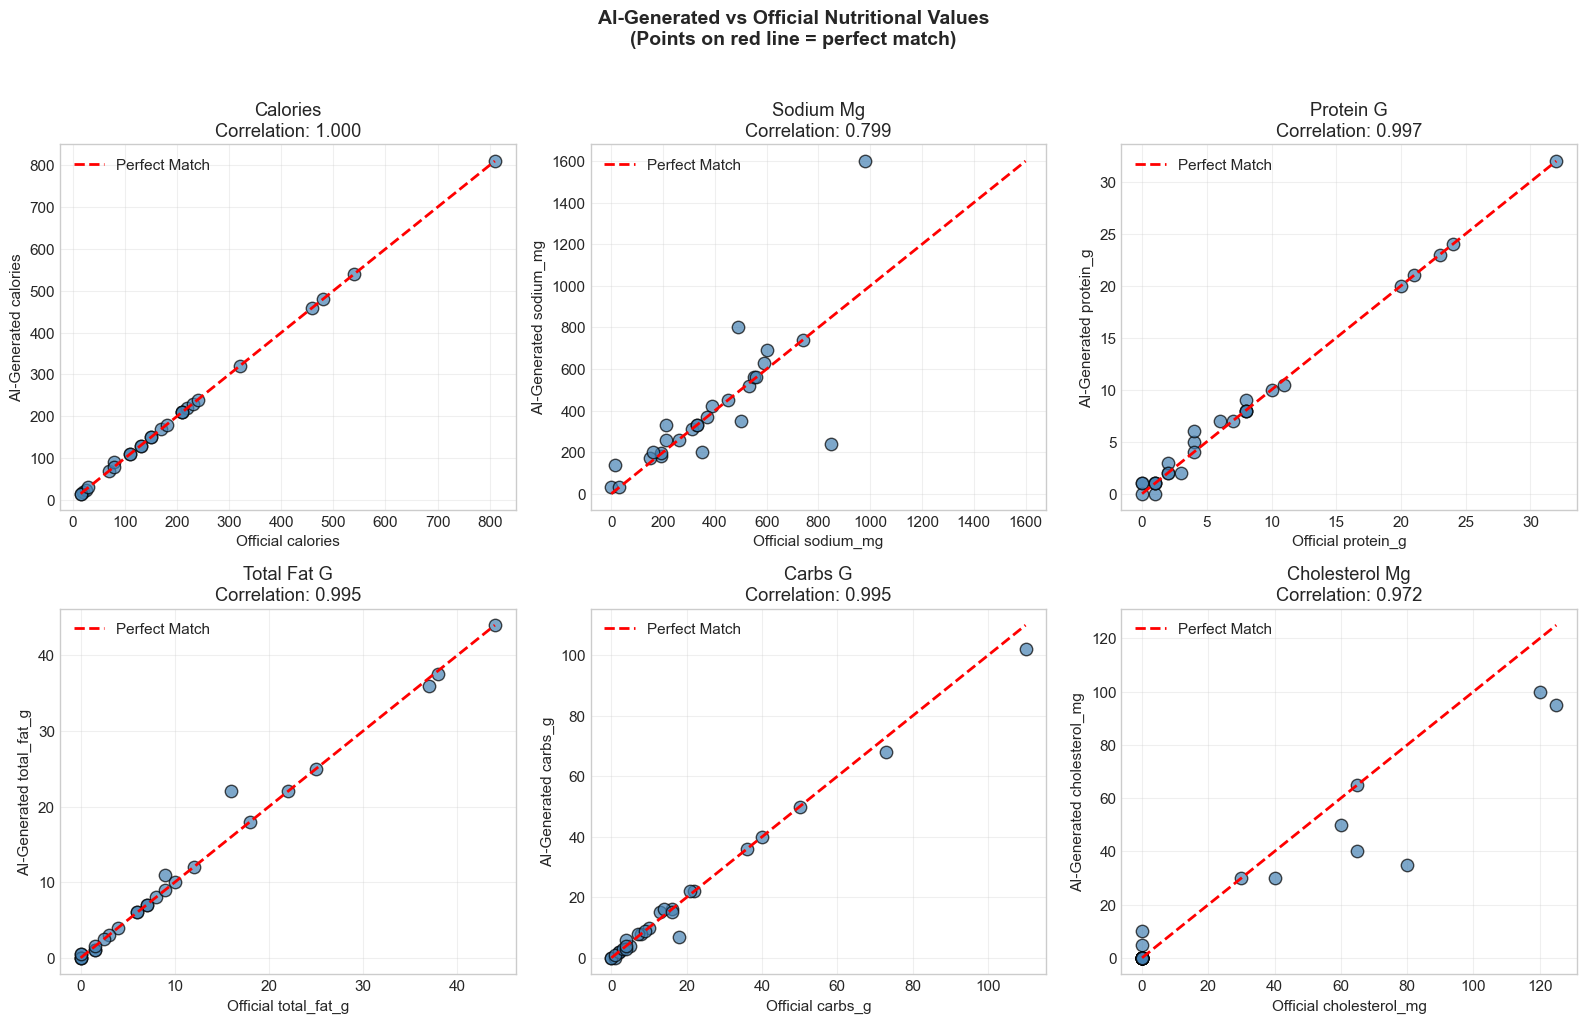

Interpretation: Points closer to the red diagonal line indicate better AI accuracy.


In [8]:
# Visualize AI vs Official comparison for key features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

key_features = ['calories', 'sodium_mg', 'protein_g', 'total_fat_g', 'carbs_g', 'cholesterol_mg']
key_features = [f for f in key_features if f in common_features][:6]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    ai_vals = artificial_matched[feature].values
    official_vals = official_matched[feature].values
    
    # Scatter plot with identity line
    ax.scatter(official_vals, ai_vals, alpha=0.7, s=80, c='steelblue', edgecolors='black')
    
    # Add identity line (perfect prediction)
    min_val = min(min(ai_vals), min(official_vals))
    max_val = max(max(ai_vals), max(official_vals))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    
    ax.set_xlabel(f'Official {feature}')
    ax.set_ylabel(f'AI-Generated {feature}')
    ax.set_title(f'{feature.replace("_", " ").title()}\nCorrelation: {error_df[error_df["feature"]==feature]["correlation"].values[0]:.3f}')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(key_features), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('AI-Generated vs Official Nutritional Values\n(Points on red line = perfect match)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ai_vs_official_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Interpretation: Points closer to the red diagonal line indicate better AI accuracy.")


Similarity Assessment

In [9]:
# Similarity Assessment: Item-level comparison

from sklearn.metrics.pairwise import cosine_similarity

# Prepare feature matrices
X_ai = artificial_matched[common_features].values
X_official = official_matched[common_features].values

# Normalize for fair comparison
scaler = StandardScaler()
X_ai_scaled = scaler.fit_transform(X_ai)
X_official_scaled = scaler.transform(X_official)

# Calculate item-level similarities
item_similarities = []

for i in range(len(X_ai)):
    # Cosine similarity
    cos_sim = 1 - cosine(X_ai_scaled[i], X_official_scaled[i])
    
    # Euclidean distance (convert to similarity)
    eucl_dist = euclidean(X_ai_scaled[i], X_official_scaled[i])
    eucl_sim = 1 / (1 + eucl_dist)  # Convert to similarity score
    
    item_similarities.append({
        'item': artificial_matched.iloc[i]['name'],
        'cosine_similarity': cos_sim,
        'euclidean_similarity': eucl_sim,
        'euclidean_distance': eucl_dist
    })

similarity_df = pd.DataFrame(item_similarities)
similarity_df = similarity_df.sort_values('cosine_similarity', ascending=True)

print("="*80)
print("ITEM-LEVEL SIMILARITY: AI vs OFFICIAL DATA")
print("="*80)
print("\nItems ranked by cosine similarity (lowest = most different from official):")
display(similarity_df.round(3))

print(f"\nOVERALL STATISTICS:")
print(f"Mean Cosine Similarity: {similarity_df['cosine_similarity'].mean():.3f}")
print(f"Std Cosine Similarity: {similarity_df['cosine_similarity'].std():.3f}")
print(f"Min Cosine Similarity: {similarity_df['cosine_similarity'].min():.3f}")
print(f"Max Cosine Similarity: {similarity_df['cosine_similarity'].max():.3f}")


ITEM-LEVEL SIMILARITY: AI vs OFFICIAL DATA

Items ranked by cosine similarity (lowest = most different from official):


,item,cosine_similarity,euclidean_similarity,euclidean_distance
12,Flour Tortilla (burrito),0.166,0.153,5.520
19,Queso Blanco (side),0.188,0.086,10.673
18,Queso Blanco (large),0.399,0.058,16.095
26,Tomatillo-Red Chili Salsa,0.682,0.348,1.872
5,Chipotle-Honey Vinaigrette,0.772,0.174,4.760
23,Steak,0.854,0.386,1.592
14,Fresh Tomato Salsa,0.866,0.452,1.211
0,Barbacoa,0.928,0.475,1.103
22,Sour Cream,0.946,0.574,0.741
17,Pinto Beans,0.946,0.554,0.805



OVERALL STATISTICS:
Mean Cosine Similarity: 0.870
Std Cosine Similarity: 0.238
Min Cosine Similarity: 0.166
Max Cosine Similarity: 1.000


In [10]:
# Jaccard Similarity: Binary profile comparison
# Convert continuous values to binary (high/low) based on median thresholds

def create_binary_profile(df, features, threshold_type='median'):
    """
    Convert continuous nutritional values to binary categories.
    1 = above threshold (high), 0 = below threshold (low)
    """
    binary_df = pd.DataFrame()
    
    for feature in features:
        if threshold_type == 'median':
            # Use combined median as threshold
            combined_values = np.concatenate([
                artificial_matched[feature].values, 
                official_matched[feature].values
            ])
            threshold = np.median(combined_values)
        else:
            threshold = df[feature].median()
        
        binary_df[f'{feature}_high'] = (df[feature] > threshold).astype(int)
    
    return binary_df

# Create binary profiles for both datasets
binary_ai = create_binary_profile(artificial_matched, common_features)
binary_official = create_binary_profile(official_matched, common_features)

# Calculate Jaccard similarity for each item pair
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two binary vectors"""
    intersection = np.sum(np.logical_and(set1, set2))
    union = np.sum(np.logical_or(set1, set2))
    return intersection / union if union > 0 else 0

jaccard_similarities = []
for i in range(len(binary_ai)):
    js = jaccard_similarity(binary_ai.iloc[i].values, binary_official.iloc[i].values)
    jaccard_similarities.append({
        'item': artificial_matched.iloc[i]['name'],
        'jaccard_similarity': js
    })

jaccard_df = pd.DataFrame(jaccard_similarities)
jaccard_df = jaccard_df.sort_values('jaccard_similarity', ascending=True)

print("="*80)
print("JACCARD SIMILARITY: Binary Profile Comparison")
print("="*80)
print("\nJaccard similarity measures agreement on categorical nutritional properties")
print("(e.g., both sources agree item is 'high protein' or 'low sodium')")
print("\nItems ranked by Jaccard similarity:")
display(jaccard_df.round(3))

print(f"\nOVERALL JACCARD STATISTICS:")
print(f"Mean Jaccard Similarity: {jaccard_df['jaccard_similarity'].mean():.3f}")
print(f"Items with perfect categorical match (Jaccard=1.0): {(jaccard_df['jaccard_similarity']==1.0).sum()}")
print(f"Items with >80% categorical match: {(jaccard_df['jaccard_similarity']>=0.8).sum()}")


JACCARD SIMILARITY: Binary Profile Comparison

Jaccard similarity measures agreement on categorical nutritional properties
(e.g., both sources agree item is 'high protein' or 'low sodium')

Items ranked by Jaccard similarity:


,item,jaccard_similarity
26,Tomatillo-Red Chili Salsa,0.500
14,Fresh Tomato Salsa,0.500
5,Chipotle-Honey Vinaigrette,0.625
9,Cilantro-Lime White Rice,0.667
12,Flour Tortilla (burrito),0.700
1,Black Beans,0.750
17,Pinto Beans,0.750
22,Sour Cream,0.800
0,Barbacoa,0.833
6,Chips (large),0.889



OVERALL JACCARD STATISTICS:
Mean Jaccard Similarity: 0.877
Items with perfect categorical match (Jaccard=1.0): 14
Items with >80% categorical match: 20


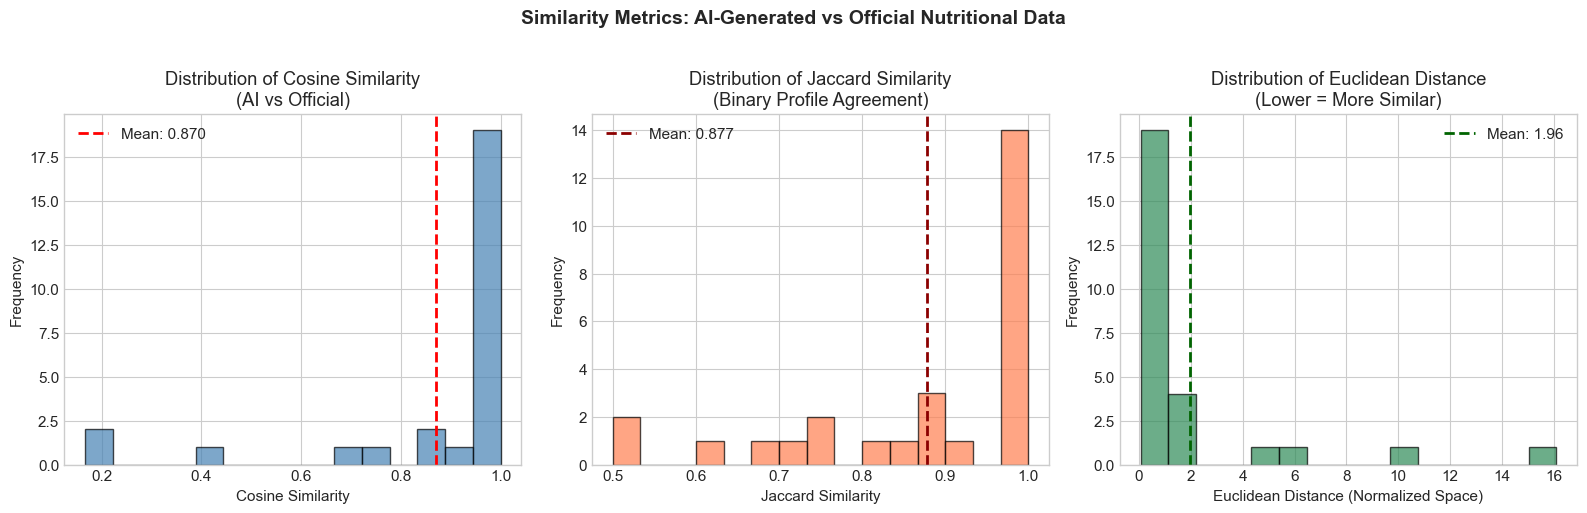

In [11]:
# Visualize similarity distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Cosine similarity distribution
axes[0].hist(similarity_df['cosine_similarity'], bins=15, color='steelblue', 
             edgecolor='black', alpha=0.7)
axes[0].axvline(similarity_df['cosine_similarity'].mean(), color='red', 
                linestyle='--', lw=2, label=f'Mean: {similarity_df["cosine_similarity"].mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Cosine Similarity\n(AI vs Official)')
axes[0].legend()

# Jaccard similarity distribution
axes[1].hist(jaccard_df['jaccard_similarity'], bins=15, color='coral', 
             edgecolor='black', alpha=0.7)
axes[1].axvline(jaccard_df['jaccard_similarity'].mean(), color='darkred', 
                linestyle='--', lw=2, label=f'Mean: {jaccard_df["jaccard_similarity"].mean():.3f}')
axes[1].set_xlabel('Jaccard Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Jaccard Similarity\n(Binary Profile Agreement)')
axes[1].legend()

# Euclidean distance distribution  
axes[2].hist(similarity_df['euclidean_distance'], bins=15, color='seagreen', 
             edgecolor='black', alpha=0.7)
axes[2].axvline(similarity_df['euclidean_distance'].mean(), color='darkgreen', 
                linestyle='--', lw=2, label=f'Mean: {similarity_df["euclidean_distance"].mean():.2f}')
axes[2].set_xlabel('Euclidean Distance (Normalized Space)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Euclidean Distance\n(Lower = More Similar)')
axes[2].legend()

plt.suptitle('Similarity Metrics: AI-Generated vs Official Nutritional Data', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('similarity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


Clustering Analysis

In [12]:
# K-Means Clustering Comparison
# Determine optimal k using silhouette analysis on combined data

silhouette_scores = []
k_range = range(2, min(8, len(X_ai_scaled)))

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_ai_scaled)
    score = silhouette_score(X_ai_scaled, labels)
    silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k based on silhouette score: {optimal_k}")

# Apply K-Means to both datasets with optimal k
kmeans_ai = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_official = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

clusters_ai = kmeans_ai.fit_predict(X_ai_scaled)
clusters_official = kmeans_official.fit_predict(X_official_scaled)

artificial_matched['cluster_ai'] = clusters_ai
official_matched['cluster_official'] = clusters_official

print(f"\nAI Data Cluster Distribution:")
print(pd.Series(clusters_ai).value_counts().sort_index())
print(f"\nOfficial Data Cluster Distribution:")
print(pd.Series(clusters_official).value_counts().sort_index())


Optimal k based on silhouette score: 2

AI Data Cluster Distribution:
0    22
1     5
Name: count, dtype: int64

Official Data Cluster Distribution:
0    25
1     2
Name: count, dtype: int64


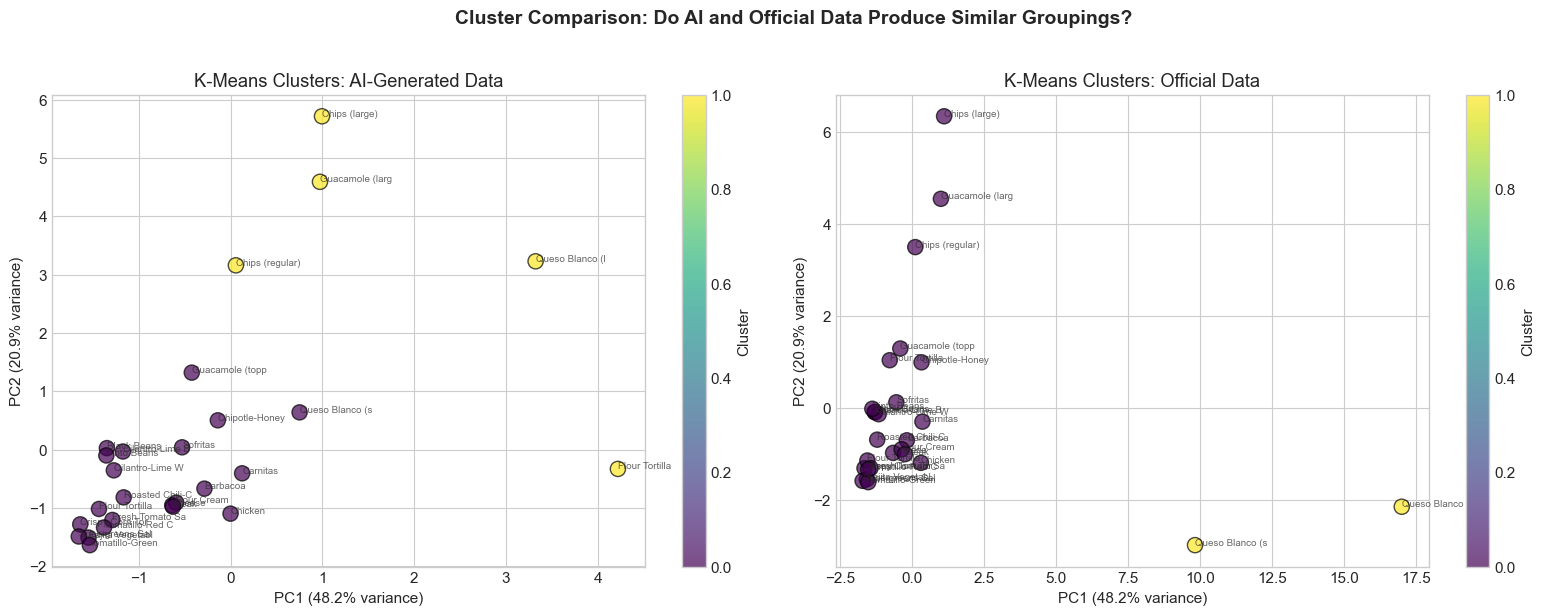

In [13]:
# Visualize clusters using PCA
pca = PCA(n_components=2)

# Fit PCA on combined data
combined_scaled = np.vstack([X_ai_scaled, X_official_scaled])
pca.fit(combined_scaled)

X_ai_pca = pca.transform(X_ai_scaled)
X_official_pca = pca.transform(X_official_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AI Data Clusters
scatter1 = axes[0].scatter(X_ai_pca[:, 0], X_ai_pca[:, 1], c=clusters_ai, 
                           cmap='viridis', s=120, alpha=0.7, edgecolors='black')
for i, name in enumerate(artificial_matched['name']):
    axes[0].annotate(name[:15], (X_ai_pca[i, 0], X_ai_pca[i, 1]), fontsize=7, alpha=0.7)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('K-Means Clusters: AI-Generated Data')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Official Data Clusters
scatter2 = axes[1].scatter(X_official_pca[:, 0], X_official_pca[:, 1], c=clusters_official, 
                           cmap='viridis', s=120, alpha=0.7, edgecolors='black')
for i, name in enumerate(official_matched['name']):
    axes[1].annotate(name[:15], (X_official_pca[i, 0], X_official_pca[i, 1]), fontsize=7, alpha=0.7)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1].set_title('K-Means Clusters: Official Data')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.suptitle('Cluster Comparison: Do AI and Official Data Produce Similar Groupings?', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cluster_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


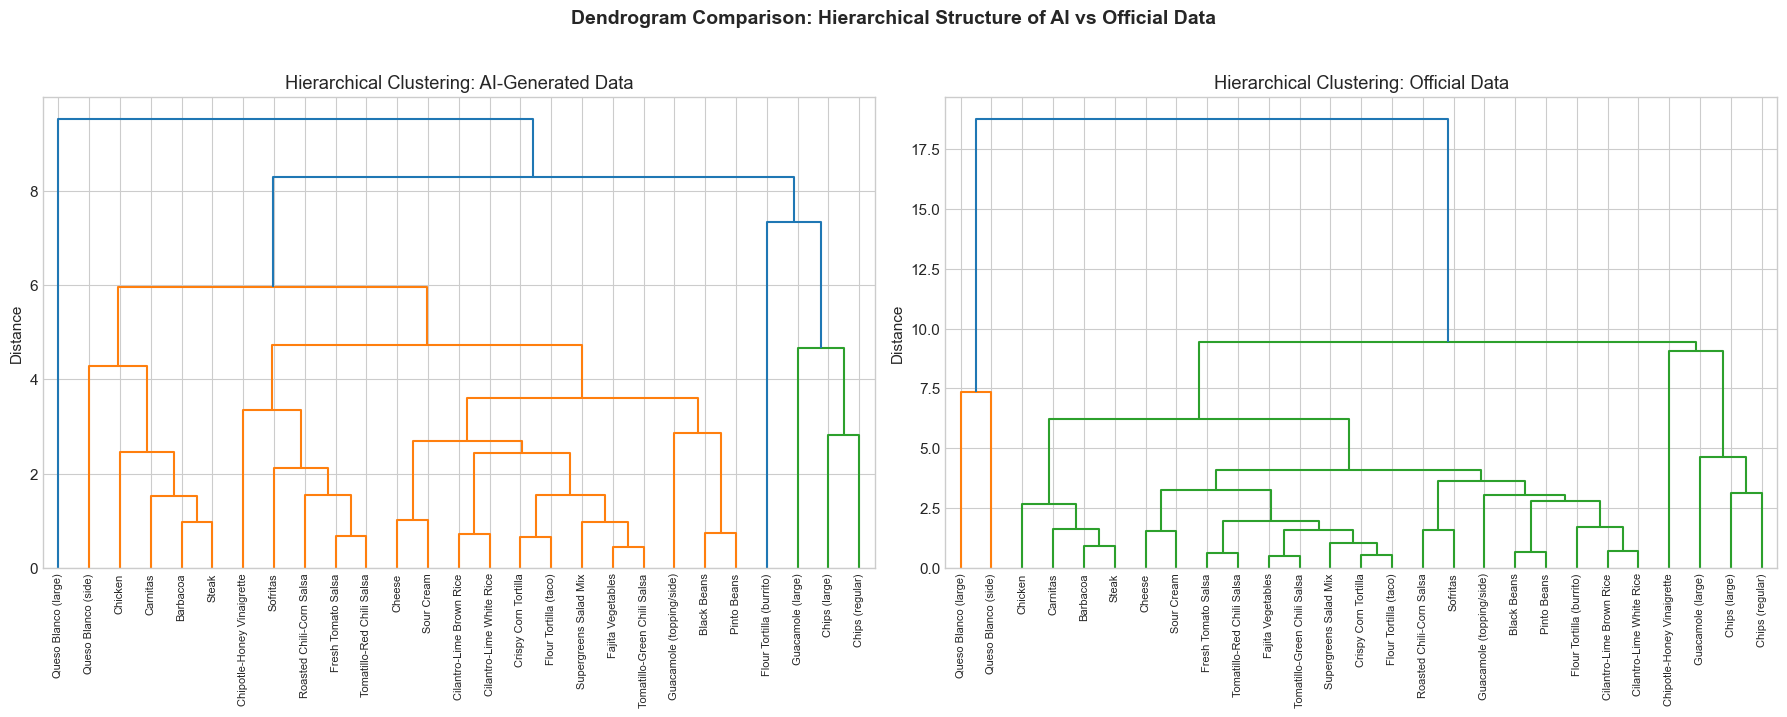

Visual inspection: Compare branching patterns to assess structural similarity.


In [14]:
# Hierarchical Clustering Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# AI Data Dendrogram
linkage_ai = linkage(X_ai_scaled, method='complete')
dendrogram(linkage_ai, labels=artificial_matched['name'].values, 
           leaf_rotation=90, leaf_font_size=8, ax=axes[0])
axes[0].set_title('Hierarchical Clustering: AI-Generated Data')
axes[0].set_ylabel('Distance')

# Official Data Dendrogram
linkage_official = linkage(X_official_scaled, method='complete')
dendrogram(linkage_official, labels=official_matched['name'].values, 
           leaf_rotation=90, leaf_font_size=8, ax=axes[1])
axes[1].set_title('Hierarchical Clustering: Official Data')
axes[1].set_ylabel('Distance')

plt.suptitle('Dendrogram Comparison: Hierarchical Structure of AI vs Official Data', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('dendrogram_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visual inspection: Compare branching patterns to assess structural similarity.")


Supervised Learning Analysis

In [15]:
# Prepare classification dataset
# Combine AI and Official data with source labels
X_combined = np.vstack([X_ai_scaled, X_official_scaled])
y_combined = np.array(['AI-Generated'] * len(X_ai_scaled) + ['Official'] * len(X_official_scaled))

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.3, random_state=42, stratify=y_combined
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in training: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Class distribution in test: {pd.Series(y_test).value_counts().to_dict()}")


Training set size: 37
Test set size: 17
Class distribution in training: {'Official': 19, 'AI-Generated': 18}
Class distribution in test: {'AI-Generated': 9, 'Official': 8}


In [16]:
# Train Logistic Regression
print("="*80)
print("LOGISTIC REGRESSION - AI DETECTION MODEL")
print("="*80)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Cross-validation for robust evaluation
cv_scores_lr = cross_val_score(lr, X_combined, y_combined, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std()*2:.3f})")

# Test set evaluation
y_pred_lr = lr.predict(X_test)
print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Feature importance (coefficient magnitudes)
feature_importance_lr = pd.DataFrame({
    'feature': common_features,
    'coefficient': np.abs(lr.coef_[0])
}).sort_values('coefficient', ascending=False)

print("\nFeatures most useful for detecting AI-generated data:")
display(feature_importance_lr)


LOGISTIC REGRESSION - AI DETECTION MODEL
Cross-Validation Accuracy: 0.409 (+/- 0.199)

Test Set Accuracy: 0.235

Classification Report:
              precision    recall  f1-score   support

AI-Generated       0.25      0.22      0.24         9
    Official       0.22      0.25      0.24         8

    accuracy                           0.24        17
   macro avg       0.24      0.24      0.24        17
weighted avg       0.24      0.24      0.24        17


Features most useful for detecting AI-generated data:


,feature,coefficient
5,cholesterol_mg,1.017630
7,carbs_g,0.665162
10,protein_g,0.649493
1,cal_from_fat,0.404796
2,total_fat_g,0.390306
8,dietary_fiber_g,0.210607
9,sugar_g,0.187768
3,saturated_fat_g,0.172984
6,sodium_mg,0.152969
0,calories,0.149793


In [17]:
# Train Random Forest Classifier
print("="*80)
print("RANDOM FOREST - AI DETECTION MODEL")
print("="*80)

rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_train, y_train)

# Cross-validation
cv_scores_rf = cross_val_score(rf, X_combined, y_combined, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std()*2:.3f})")

# Test set evaluation
y_pred_rf = rf.predict(X_test)
print(f"\nTest Set Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': common_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
display(feature_importance_rf)


RANDOM FOREST - AI DETECTION MODEL
Cross-Validation Accuracy: 0.484 (+/- 0.231)

Test Set Accuracy: 0.235

Classification Report:
              precision    recall  f1-score   support

AI-Generated       0.30      0.33      0.32         9
    Official       0.14      0.12      0.13         8

    accuracy                           0.24        17
   macro avg       0.22      0.23      0.22        17
weighted avg       0.23      0.24      0.23        17


Random Forest Feature Importance:


,feature,importance
3,saturated_fat_g,0.165427
7,carbs_g,0.126501
1,cal_from_fat,0.120850
5,cholesterol_mg,0.108855
6,sodium_mg,0.101518
10,protein_g,0.087481
2,total_fat_g,0.081568
0,calories,0.079327
9,sugar_g,0.062177
8,dietary_fiber_g,0.056907


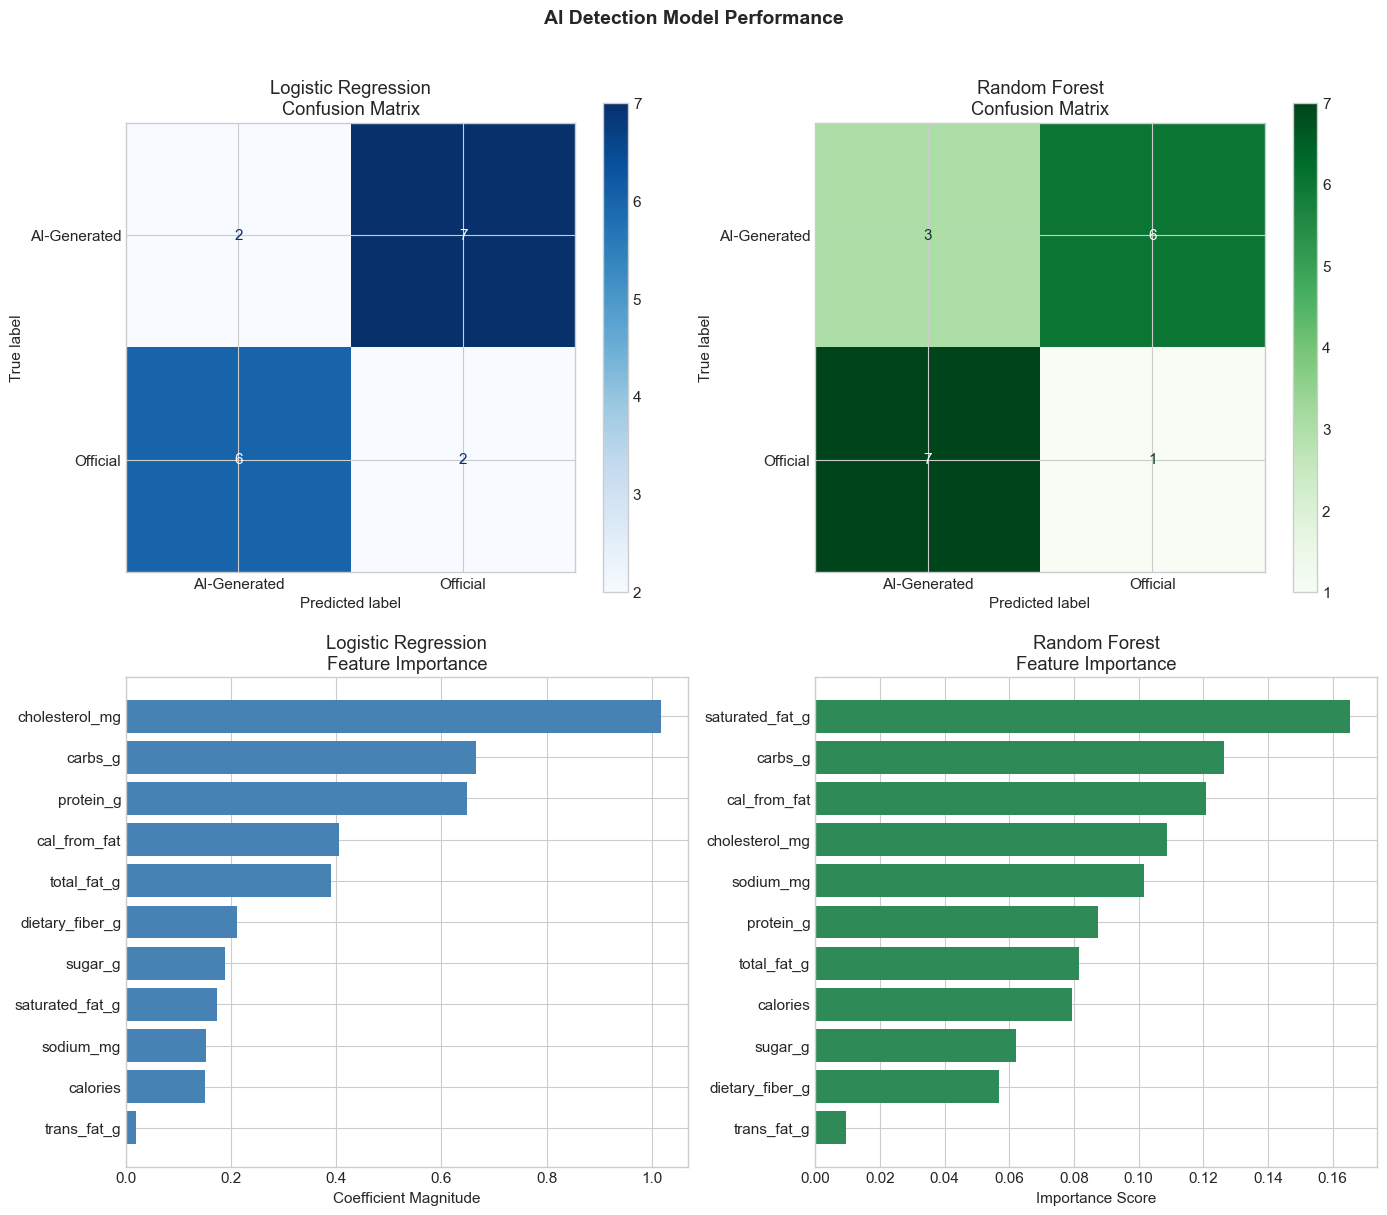

In [18]:
# Visualize classifier results
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrices
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('Logistic Regression\nConfusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=axes[0, 1], cmap='Greens')
axes[0, 1].set_title('Random Forest\nConfusion Matrix')

# Feature Importance Comparison
feature_importance_lr_sorted = feature_importance_lr.sort_values('coefficient')
axes[1, 0].barh(feature_importance_lr_sorted['feature'], feature_importance_lr_sorted['coefficient'], 
                color='steelblue')
axes[1, 0].set_xlabel('Coefficient Magnitude')
axes[1, 0].set_title('Logistic Regression\nFeature Importance')

feature_importance_rf_sorted = feature_importance_rf.sort_values('importance')
axes[1, 1].barh(feature_importance_rf_sorted['feature'], feature_importance_rf_sorted['importance'], 
                color='seagreen')
axes[1, 1].set_xlabel('Importance Score')
axes[1, 1].set_title('Random Forest\nFeature Importance')

plt.suptitle('AI Detection Model Performance', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('classification_results.png', dpi=300, bbox_inches='tight')
plt.show()
